In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/wl/8bwvr7jj1v9dc7lxf7ykgzr40000gn/T/ipykernel_22849/4196587217.py:4: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd67aa26be0>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397'}

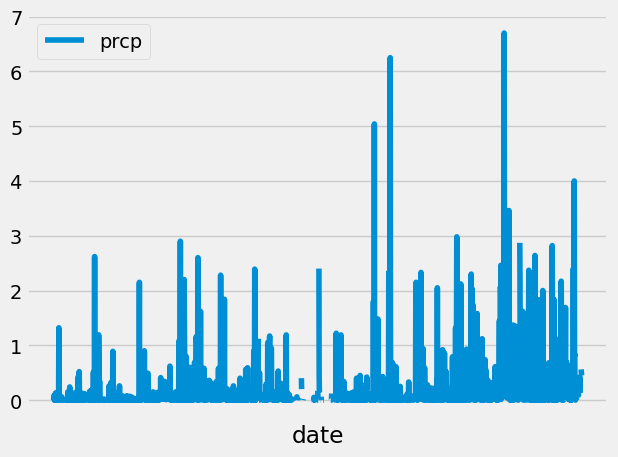

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


last_date = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.

# Convert object type
entered_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
entered_date = entered_date.date()



yr_ago = entered_date - dt.timedelta(days=365)
yr_ago

# Perform a query to retrieve the data and precipitation scores

one_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_year_prcp, columns=['date', 'prcp'])
df.set_index('date', inplace=True)

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks([])
plt.tight_layout()
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number stations in the dataset
station_ct = session.query(Measurement.station).distinct().count()
print("Station Count:", station_ct)


Station Count: 9


In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Data Count'])
active_stations_df

,Station,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

most_active_station_tobs = session.query(*sel).\
    filter(Measurement.station==most_active_station).all()[0]

print(f"Temperature Minimum: {most_active_station_tobs[0]}")
print(f"Temperature Average: {most_active_station_tobs[1]}")
print(f"Temperature Maximum: {most_active_station_tobs[2]}")


Temperature Minimum: 54.0
Temperature Average: 71.66378066378067
Temperature Maximum: 85.0


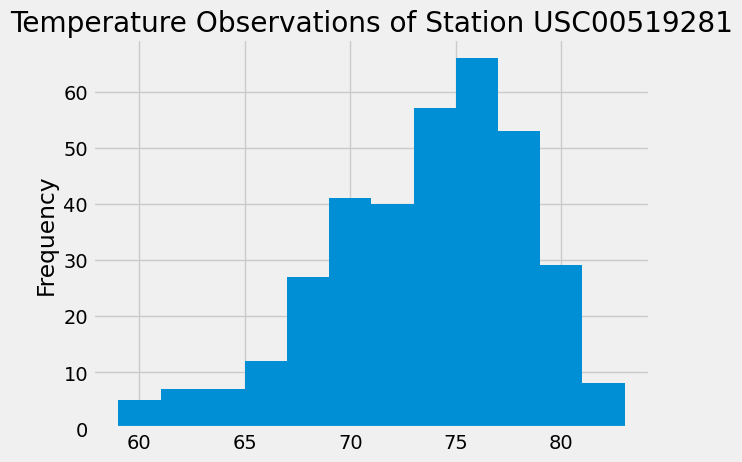

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stn_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.station==most_active_station).all()

tobs_array = np.ravel(stn_tobs)
tobs_series = pd.Series(tobs_array)

tobs_series.plot.hist(bins=12)
plt.title("Temperature Observations of Station USC00519281")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()